# Synthetic PSD data and Finding an optimal cut.

Pulse shape discrimination is deceptively complicated.
Sure, the pulse shapes look different, and you can pretty easily come up with a metric to quantitatively describe this difference (like $Q_{fast}/Q_{total}$).
Then you can make a simple cut, maybe with some crude optimisation of the cut location.
Simple.
But, if you want to do any of these things optimally, it gets complicated quickly.

I think that machine learning has a lot of tools that it can bring to bear upon PSD.
At its heart, it's a classification problem, and by using $Q_{fast}/Q_{total}$ we're doing some feature engineering (the number of features goes from the initial number of samples in the waveform to a ratio of two features, more or less). This is crude. Maybe a better approach would be to use PCA to select some important features, then use a classifier like a support vector classifier to discriminate between neutrons and gammas. Let's make that the aim, and see if it does any better than the usual approach.

Of course, first we need to have a labelled set of data. This means we need to be able to distinguish noise (easy enough to measure), neutrons, and gammas. For neutrons, we just so happen to be planning an experiment where we'll be tagging neutron events in a detector. So that's good. And it should be easy enough to measure gamma rays. We need to generate enough statistics over a wide enough energy range to describe the detector response space. It isn't clear that that's do-able for neutrons, but for gammas it should be easy enough.

Things to do:

- Get a sample of labelled raw detector pulses, taken over an energy range that we expect to span our detector response space. We may need to do some processing to align the pulses, etc. but the features will be the samples from the digitizer.

- Do some dimension reduction (PCA?) to engineer maximally informative features.

- Train a classifier on the labelled samples with the engineered features, doing proper cross-validation.

- Take some real data in a mixed field. Note that the basic detector conditions should be the same (same HV, thresholds, electronics, impedances, and a similar enough event rate). Use the classifier to sort neutrons and gammas. 

Other thoughts:

- More validation: it should be possible to do regular calibrations using a gamma source. If SABRE wants to include something like this in the detector, then they could use a gamma source (or several) and an AmC source (no gamma rays).

- This would be significantly easier to do in a liquid scintillator, as you can spike it (for instance, a parent $\alpha$-decays to a metastable state then the metastable daughter gives off a low energy gamma a few ms later. Self-labelling data.

- This seems to have been looked at back in 2012: http://ieeexplore.ieee.org/abstract/document/6551092/ (paywalled). Also this one: http://iopscience.iop.org/article/10.1088/1748-0221/8/05/P05023/meta and this one: http://www.sciencedirect.com/science/article/pii/S0168900214015551?np=y&npKey=ea5f167b412e73317e14d2199379b19c9ec135c609f8d2c54221891a90c108cb.

- A (naive?) criticism of a ML approach is that we do actually know quite a bit about the physics of scintillators, so it should be possible to make a model of the waveforms and do fits on a case-by-case basis. Then you can do classification on the fit parameters. The problem here is that waveforms rarely look as nice as you'd expect; and the causes of the not-niceness are often experimentally inacessable (it might be an impedance mismatch from a slightly corroded connector, for instance). This argues for *in situ* measurements that are agnostic to any model (or at least are flexible enough to accomodate reasonable deviations from the model.

There are a few things I should play with before I can feel ready to tackle the PSD problem. Let's start with the feature engineering.


## Feature Engineering

[This blog](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html) has a really good discussion of the difference between PCA and Mutiple Discriminant Analysis (MDA).

- PCA: project the entire set of samples onto a new feature subspace, where the basis vectors of the space are chosen so that they maximise the variance of the data (in decreasing order).

- MDA: project the entire set of labelled samples onto a new feature subspace, where the basis vectors of the space are chosen so that they maximise the separation between the classes.

I think it's clear that MDA is by design much better. I think this is AKA a Fisher discriminant. This makes sense: the context in which I read about Fisher discriminants was finding a cut that isn't a straight line. It works by projecting the data onto another space where the cut *is* a straight line.

So I'll use a discriminant (known as a Multiple Discriminant Analysis, Linear/Quadradic Discriminant Analysis, and Fisher Discriminant Analysis).

Let's first look at sklearn's tutorial, which uses the iris dataset:

In [179]:
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

explained variance ratio (first two components): [ 0.92461621  0.05301557]


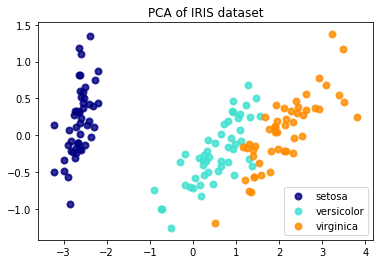

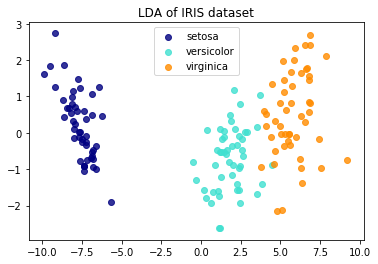

In [3]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

OK, that's a bit too easy.
Let's see what happens if I try and give it something more realistic.
I'll synthesise some waveform pulses for neutrons and gammas, using the shape of the waveform as:

$y\left(t\right) = \frac{\tau_{r} + \tau_{d}}{\tau_{d}^{2}}\left(1 - e^{-\frac{t}{\tau_{r}}}\right)\left(A_{f}e^{-\frac{t}{\tau_{f}}} + A_{s}e^{-\frac{t}{\tau_{s}}}\right)$

Where $\tau_{d} = \tau_{f} + \tau_{s}$, for the fast and slow decay components.

Gammas: 1.0, Neutrons: 1.0


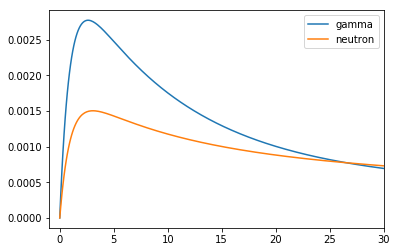

In [69]:
t_r = 1.
t_f = 10.
t_s = 100.
A_f = 0.8
A_s = 0.2
xvals = np.linspace(0, 1000, 10001)
const = ((t_r + t_f + t_s)/((t_f + t_s)**2))
yvals_gamma = (1-np.exp(-xvals/t_r))*(A_f*np.exp(-xvals/t_f) + A_s*np.exp(-xvals/t_s))
yvals_gamma /= sum(yvals_gamma)
A_f = 0.5
A_s = 0.5
yvals_neutron = (1-np.exp(-xvals/t_r))*(A_f*np.exp(-xvals/t_f) + A_s*np.exp(-xvals/t_s))
yvals_neutron /= sum(yvals_neutron)
plt.plot(xvals, yvals_gamma, label='gamma')
plt.plot(xvals, yvals_neutron, label='neutron')
#plt.yscale('log')
plt.legend()
plt.xlim(-1, 30)
print("Gammas: {0}, Neutrons: {1}".format(sum(yvals_gamma), sum(yvals_neutron)))

Those look OK.
Now let's add some noise and smear the timing with a Gaussian:

Gammas: 0.498687170265, Neutrons: 0.503821801783
12000


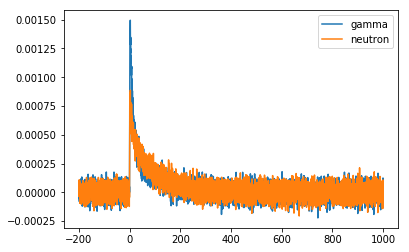

In [65]:
Wfm_gamma = np.random.normal(0, 0.0002, 12000)
Wfm_gamma[1999:] += yvals_gamma
Wfm_neutron = np.random.normal(0,0.0002, 12000)
Wfm_neutron[1999:] += yvals_neutron
conv_sigma = 2
conv_mean = 0
conv_kernel = (1./np.sqrt(2*np.pi*conv_sigma**2))*np.exp(-0.5*(((np.linspace(-10,10,11)-conv_mean)/conv_sigma)**2))
conv_mode = 'same'
Wfm_gamma = np.convolve(Wfm_gamma, conv_kernel, mode = conv_mode)
Wfm_neutron = np.convolve(Wfm_neutron, conv_kernel, mode = conv_mode)
timevals = np.linspace(-200, 1000, len(Wfm_neutron))
plt.plot(timevals, Wfm_gamma, label='gamma')
plt.plot(timevals, Wfm_neutron, label='neutron')
plt.legend()
print("Gammas: {0}, Neutrons: {1}".format(sum(Wfm_gamma), sum(Wfm_neutron)))
print(len(Wfm_gamma))

Great! So now I want to synthesise some labelled waveform data.
I'll have three groups:

- Neutrons: they all have the same shape and noise level, but the underlying signal is multiplied by a factor which is sampled from an exponential distribution.

- Gammas: They also all have the same shape and noise level, but the underlying signal is multiplied by a factor which is sampled from an exponential distribution.

- Noise: Synthesise some waveforms with just the constant noise level.

Then I'll do a linear discriminant analysis, compare it with the traditional $Q_{fast}/Q_{total}$ analysis, and go from there...

In [92]:
def get_wfm(particle_type):
    """
    Return the unmodified waveform for a particle interaction ('gamma' or 'neutron').
    """
    #Scintillator parameters
    t_r = 1.
    t_f = 10.
    t_s = 100.
    if 'gamma' in particle_type.lower():
        A_f = 0.8
        A_s = 0.2
    elif 'neutron' in particle_type.lower():
        A_f = 0.5
        A_s = 0.5
    else:
        print("Error: Unknown particle type {0}".format(particle_type))

    xvals = np.linspace(0, 1000, 10001)
    yvals = (1-np.exp(-xvals/t_r))*(A_f*np.exp(-xvals/t_f) + A_s*np.exp(-xvals/t_s))
    return np.random.exponential(scale=1)*yvals/sum(yvals)

#Set up convolution parameters
conv_sigma = 2
conv_mean = 0
conv_kernel = (1./np.sqrt(2*np.pi*conv_sigma**2))*np.exp(-0.5*(((np.linspace(-10,10,11)-conv_mean)/conv_sigma)**2))
conv_mode = 'same'

noise_lvl = 0.0003

Ngammas = 1000 #12000 x 1000 array ~ 96 MB
Gammas = np.random.normal(0, noise_lvl, (12000, Ngammas))
for i in range(Ngammas):
    Gammas[1999:, i] += get_wfm('gamma')
    Gammas[:, i] = np.convolve(Gammas[:, i], conv_kernel, mode = conv_mode)
    
Nneutrons = 1000 #12000 x 1000 array ~ 96 MB
Neutrons = np.random.normal(0, noise_lvl, (12000, Nneutrons))
for i in range(Nneutrons):
    Neutrons[1999:, i] += get_wfm('neutrons')
    Neutrons[:, i] = np.convolve(Neutrons[:, i], conv_kernel, mode = conv_mode)
    
Nnoise = 1000 #12000 x 1000 array ~ 96 MB
Noise = np.random.normal(0, noise_lvl, (12000, Nnoise))
for i in range(Nnoise):
    Noise[:, i] = np.convolve(Noise[:, i], conv_kernel, mode = conv_mode)


Crude FOM: 0.0300150257988
Half-way cut: 0.295560445553


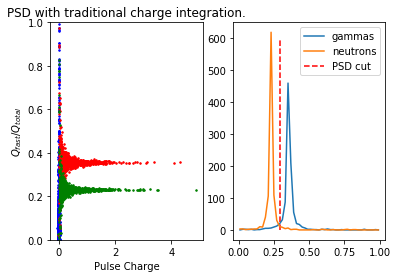

In [184]:
#Lets define the fast integration region as 190:220, and the total integration region as 190:.
Qf_gamma = np.sum(Gammas[1900:2200, :], axis=0)
Qt_gamma = np.sum(Gammas[1900:, :], axis=0)

Qf_neut = np.sum(Neutrons[1900:2200, :], axis=0)
Qt_neut = np.sum(Neutrons[1900:, :], axis=0)

Qf_noise = np.sum(Noise[1900:2200, :], axis=0)
Qt_noise = np.sum(Noise[1900:, :], axis=0)

plt.subplot(1,2,1)
plt.plot(Qt_noise, Qf_noise/Qt_noise, 'b.', markersize=3, label="Noise")
plt.plot(Qt_gamma, Qf_gamma/Qt_gamma, 'r.', markersize=3, label='Gammas')
plt.plot(Qt_neut, Qf_neut/Qt_neut, 'g.', markersize=3, label='Neutrons')
plt.ylim(0,1)
plt.xlabel("Pulse Charge")
plt.ylabel("$Q_{fast}/Q_{total}$")
plt.title('PSD with traditional charge integration.')

h_PSDg, binedges = np.histogram(Qf_gamma/Qt_gamma, bins=50, range=(0,1))
bincentres = binedges[:-1] + (binedges[1]-binedges[0])/2
h_PSDn, binedges = np.histogram(Qf_neut/Qt_neut, bins=50, range=(0,1))
plt.subplot(1,2,2)
plt.plot(bincentres, h_PSDg, label='gammas')
plt.plot(bincentres, h_PSDn, label='neutrons')
print("Crude FOM: {0}".format((np.mean(Qf_gamma/Qt_gamma)-np.mean(Qf_neut/Qt_neut))/
                              2.35482*(np.std(Qf_gamma/Qt_gamma)+np.std(Qf_neut/Qt_neut))))
PSDcut = (np.mean(Qf_gamma/Qt_gamma)+np.mean(Qf_neut/Qt_neut))/2
print("Half-way cut: {0}".format(PSDcut))
plt.vlines(PSDcut, ymin=0, ymax=600, 
           colors='r', linestyles='dashed', label='PSD cut')
PSDcut_min = min((np.mean(Qf_gamma/Qt_gamma), np.mean(Qf_neut/Qt_neut)))
PSDcut_max = max((np.mean(Qf_gamma/Qt_gamma), np.mean(Qf_neut/Qt_neut)))
plt.legend()

f1 score: 0.949435444281
Confusion matrix, without normalization
[[930  70]
 [ 33 967]]
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.03  0.97]]


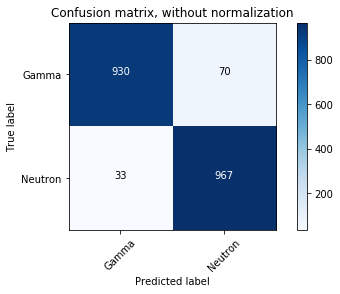

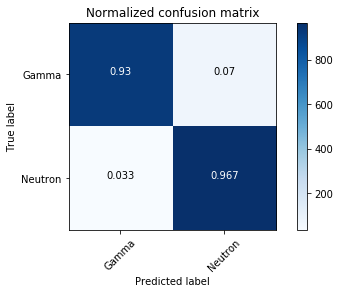

In [181]:
#Lets quantify our (mis)classification of neutrons and gammas using a confusion matrix.
#We'll make gammas 0 and neutrons 1
Neuts_predict = [0 if PSD > PSDcut else 1 for PSD in Qf_neut/Qt_neut]
Gammas_predict = [0 if PSD > PSDcut else 1 for PSD in Qf_gamma/Qt_gamma]
y_pred = np.concatenate((Gammas_predict, Neuts_predict))
y_true = np.concatenate((np.array([0]*len(Gammas_predict)),
                         np.array([1]*len(Neuts_predict))))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y_true, y_pred)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Maximum f1 score of 0.952146028614 for PSD cut at 0.288953587475
f1 score: 0.952146028614
Confusion matrix, without normalization
[[938  62]
 [ 35 965]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.04  0.96]]


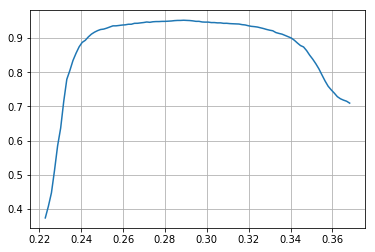

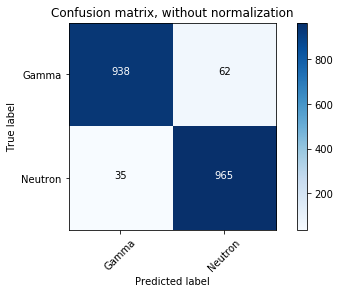

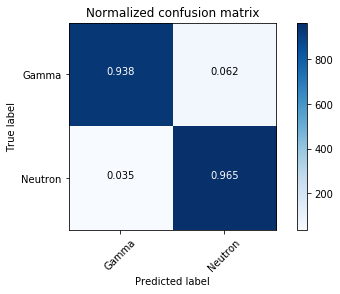

In [206]:
#Let's repeat the above analysis, but step through a bunch of PSD cuts to choose the one which optimises the f1 score:
PSDcut_vector = np.linspace(PSDcut_min, PSDcut_max, 100)
f1scores = np.empty(len(PSDcut_vector), dtype=np.float64)
for i, thisPSDcut in enumerate(PSDcut_vector):
    Neuts_predict = [0 if PSD > thisPSDcut else 1 for PSD in Qf_neut/Qt_neut]
    Gammas_predict = [0 if PSD > thisPSDcut else 1 for PSD in Qf_gamma/Qt_gamma]
    y_pred = np.concatenate((Gammas_predict, Neuts_predict))
    f1scores[i] = f1_score(y_true,y_pred)
print("Maximum f1 score of {0} for PSD cut at {1}".format(max(f1scores), PSDcut_vector[np.argmax(f1scores)]))
plt.figure()
plt.plot(PSDcut_vector, f1scores)
plt.grid()
PSDcut_optim = PSDcut_vector[np.argmax(f1scores)]
#repeat it for the optimal PSD cut:
Neuts_predict = [0 if PSD > PSDcut_optim else 1 for PSD in Qf_neut/Qt_neut]
Gammas_predict = [0 if PSD > PSDcut_optim else 1 for PSD in Qf_gamma/Qt_gamma]
y_pred_optim = np.concatenate((Gammas_predict, Neuts_predict))
cnf_matrix_optim = confusion_matrix(y_true, y_pred_optim)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y_true, y_pred_optim)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_optim, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_optim, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Awesomesauce! That looks just like it should!
Now let's train a linear discriminant using labelled noise (=0), gammas (=1), and neutrons (=2).

explained variance ratio (first two components): [ 0.69  0.03]


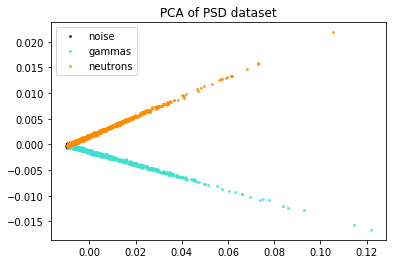

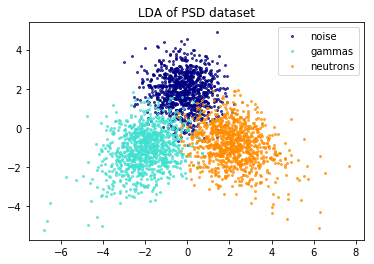

In [141]:
x_noise = np.transpose(Noise)
x_gamma = np.transpose(Gammas)
x_neutron = np.transpose(Neutrons)

y_noise = np.array([0]*Nnoise)
y_gamma = np.transpose([1]*Ngammas)
y_neutron = np.transpose([2]*Nneutrons)

X = np.concatenate((x_noise, x_gamma, x_neutron), axis=0)
y = np.concatenate((y_noise, y_gamma, y_neutron), axis=0)

ncomponents = 2
pca = PCA(n_components=ncomponents)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=ncomponents)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
types = ['noise', 'gammas', 'neutrons']

for color, i, target_name in zip(colors, [0, 1, 2], types):
    plt.plot(X_r[y == i, 0], X_r[y == i, 1], '.', color=color, alpha=.7, lw=lw,
                label=target_name, markersize=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of PSD dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], types):
    plt.plot(X_r2[y == i, 0], X_r2[y == i, 1], '.', alpha=.7, color=color,
                label=target_name, markersize=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of PSD dataset')

plt.show()

Well, that looks pretty good!
To make if a fair comparison with the $Q_{fast}/Q_{total}$ method, let's make a new transform without the noise...

explained variance ratio (first two components): [  7.36e-01   3.54e-02   3.26e-04   3.25e-04   3.21e-04   3.19e-04
   3.17e-04   3.16e-04   3.15e-04   3.13e-04]
LDA cut: 0.0


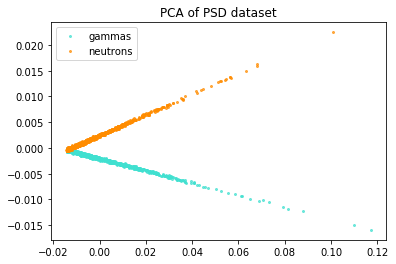

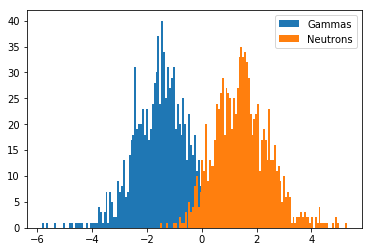

In [161]:
x_gamma = np.transpose(Gammas[1900:,:])
x_neutron = np.transpose(Neutrons[1900:,:])

y_gamma = np.transpose([0]*Ngammas)
y_neutron = np.transpose([1]*Nneutrons)

X = np.concatenate((x_gamma, x_neutron), axis=0)
y = np.concatenate((y_gamma, y_neutron), axis=0)

ncomponents = 10
pca = PCA(n_components=ncomponents)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=ncomponents)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['turquoise', 'darkorange']
lw = 2
types = ['gammas', 'neutrons']

for color, i, target_name in zip(colors, [0, 1], types):
    plt.plot(X_r[y == i, 0], X_r[y == i, 1], '.', color=color, alpha=.7, lw=lw,
                label=target_name, markersize=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of PSD dataset')

#plt.figure()
#for color, i, target_name in zip(colors, [0, 1], types):
#    plt.plot(X_r2[y == i, 0], X_r2[y == i, 1], '.', alpha=.7, color=color,
#                label=target_name, markersize=4)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.title('LDA of PSD dataset')

plt.figure()
plt.hist(X_r2[y==0], bins=100, label='Gammas')
plt.hist(X_r2[y==1], bins=100, label='Neutrons')
plt.legend()

PSDcut_LDA = (np.mean(X_r2[y==0])+np.mean(X_r2[y==1]))/2
print("LDA cut: {0}".format(PSDcut_LDA))

plt.show()

f1 score: 0.942643391521
Confusion matrix, without normalization
[[940  60]
 [ 55 945]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.06  0.94]]


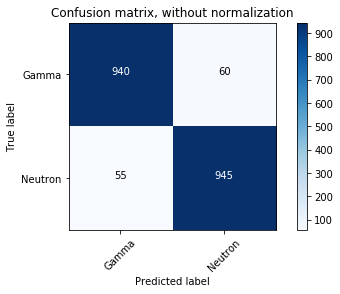

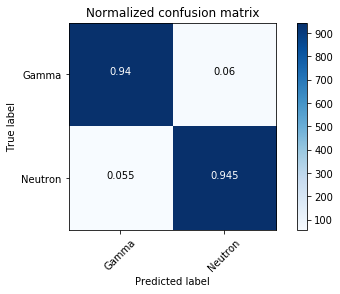

In [182]:
#Lets quantify our (mis)classification of neutrons and gammas using a confusion matrix.
Neuts_predict_LDA = [0 if PSD < PSDcut_LDA else 1 for PSD in X_r2[y==1]]
Gammas_predict_LDA = [0 if PSD < PSDcut_LDA else 1 for PSD in X_r2[y==0]]
y_pred = np.concatenate((Gammas_predict_LDA, Neuts_predict_LDA))
#y_true = np.concatenate((np.array([0]*len(Gammas_predict)),
#                         np.array([1]*len(Neuts_predict))))
cnf_matrix_LDA = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y, y_pred)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Well, that's unexpected! It seems I have misunderstood what LDA does (or at least its implemenentation in sklearn).

What I seem to have done is project the data onto a N-1 dimensional space which maximises that difference between N classes. I don't think this is what I want, since PCA seems to indicate that there are at least 2 dimensions which contribute information (or at least explain the variance in the data).

At least we have made the errors symmetric, which I guess I could do by tuning the PSD cut using the normal approach (it might be interesting to see how that goes). The f1 scores are similar but I think overall it's hard to argue that the LDA is doing any better.

But, since there are only 2 PCA dimensions that contribute information; what happens if we do LDA on those?...

(-1, 1)

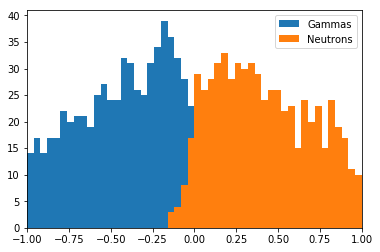

In [177]:
#I wonder what happens if we make a new LDA classifier using the PCA-decomposed data:
X_decomp = X_r[:, :2]
lda_2 = LinearDiscriminantAnalysis(n_components=2)
X_lda2 = lda_2.fit(X_decomp, y).transform(X_decomp)
plt.figure()
plt.hist(X_lda2[y==0], bins=400, range=(-8,8), label='Gammas')
plt.hist(X_lda2[y==1], bins=400, range=(-8,8), label='Neutrons')
plt.legend()
plt.xlim(-1,1)

f1 score: 0.975314861461
Confusion matrix, without normalization
[[983  17]
 [ 32 968]]
Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.03  0.97]]


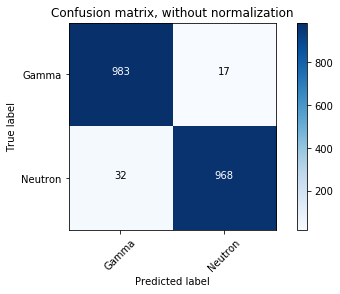

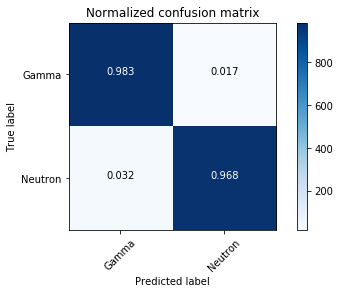

In [183]:
#Lets quantify our (mis)classification of neutrons and gammas using a confusion matrix.
Neuts_predict_LDA2 = [0 if PSD < 0 else 1 for PSD in X_lda2[y==1]]
Gammas_predict_LDA2 = [0 if PSD < 0 else 1 for PSD in X_lda2[y==0]]
y_pred_LDA2 = np.concatenate((Gammas_predict_LDA2, Neuts_predict_LDA2))
#y_true = np.concatenate((np.array([0]*len(Gammas_predict)),
#                         np.array([1]*len(Neuts_predict))))
cnf_matrix_LDA2 = confusion_matrix(y, y_pred_LDA2)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y, y_pred_LDA2)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA2, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Well, that's certainly better than either of the other attempts.
Yay!

But we can do better... For a DM experiment, what you *really* don't want is to mistake a gamma for a neutron. Mistaking neutrons for gammas is bad, but not nearly as bad. Some future work can look at minimising the number of events in the top right of the confusion matrix, while keeping the number in the bottom right low...

Other things to try:

- Do a similar thing in frequency space (it may make it easier to discriminate noise).

- Clean up noise (frequency filter, or some other way) and then do similar analysis.

- Rather than using LDA for the last step, use some other ML classifier (SVM?). This can take the first N dimensions from the PCA. The 'pipeline' feature in sklearn may be useful here.

- Investigate whether LDA can be implemented better (do we have to reduce it to # classes - 1 or can we leave it as higher dimensional? What about non-linear transforms which are achieveable using a kernel method?)

- Do these results hold for the really small amount of PSD in the SABRE energy range?